In [2]:
import pandas as pd
import pandas as pd
import numpy as np
%pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
sns.set_theme(style='ticks',palette='colorblind',font_scale=0.7)
from ext.sparql import query, display_result

## Veröffentlichungen über die Zeit

In [3]:
df = await query("""

PREFIX jolux: <http://data.legilux.public.lu/resource/ontology/jolux#>
SELECT ?Jahr (count(DISTINCT ?Act) as ?Veröffentlichungen_AS) where {
    # MemorialSerial ist die Jahresausgabe
    ?MemorialSerial jolux:isMemberOf <https://fedlex.data.admin.ch/eli/collection/oc> ;
                    jolux:memorialYear ?Jahr .
    
    #Memorial ist die Ausgabe
    ?Memorial jolux:isMemberOf ?MemorialSerial .
    ?Act jolux:isPartOf ?Memorial .
    
    # Sicherstellen, dass es sich um ein AS Eintrag handelt. Es gibt auch andere Einträge wie Compendium.
    ?Act a jolux:Act . 
    
    # Die Information aufMemorialSerial gibt es seit 1948. Die Informationen auf Memorial und Act Ebene sind unzuverlässig und oft falsch...
    FILTER(?Jahr>=1948)
}
GROUP BY ?Jahr

ORDER BY desc(?Jahr)

""", "F")

# display_result(df)
df_AS = df.astype(int)

In [32]:
df = await query("""
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX jolux: <http://data.legilux.public.lu/resource/ontology/jolux#>
SELECT ?Jahr (COUNT(DISTINCT ?SR) AS ?Inkrafttretende_SR) where {
    SELECT distinct ?Jahr ?SR {

        ?SR a jolux:ConsolidationAbstract ;
              jolux:classifiedByTaxonomyEntry/skos:notation ?SR_NR ;
              jolux:dateEntryInForce ?Datum .
        FILTER(!strstarts(str(?SR_NR), '131.') && !strstarts(str(?SR_NR), '0.'))
        FILTER(?Datum > xsd:date("1948") && ?Datum <= now() )    
        BIND( year(?Datum) AS ?Jahr)
    }
}
GROUP BY ?Jahr

ORDER BY desc(?Jahr)

""", "F")

#display_result(df)
df_SR_i = df.astype(int)

In [31]:
df = await query("""
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX jolux: <http://data.legilux.public.lu/resource/ontology/jolux#>
SELECT ?Jahr (COUNT(DISTINCT ?SR) AS ?Aufhebungen_SR) WHERE {
    SELECT distinct ?Jahr ?SR WHERE {

        ?SR a jolux:ConsolidationAbstract ;
              jolux:classifiedByTaxonomyEntry/skos:notation ?SR_NR ;
              jolux:dateNoLongerInForce ?Datum .
        FILTER(!strstarts(str(?SR_NR), '131.') && !strstarts(str(?SR_NR), '0.'))
        FILTER(?Datum > xsd:date("1948") && ?Datum <= now() )    
        BIND( year(?Datum) AS ?Jahr)
    }
}
GROUP BY ?Jahr

ORDER BY desc(?Jahr)

""", "F")

#display_result(df)
df_SR_a = df.astype(int)

In [29]:
query_template = """
    PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
    PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
    PREFIX jolux: <http://data.legilux.public.lu/resource/ontology/jolux#>
    SELECT ?Jahr (COUNT(DISTINCT ?SR) AS ?SR_im_geltenden_Recht) WHERE {
            values ?Jahr { 'PYTHON_YEAR' }
            BIND(xsd:date(concat(?Jahr, '-12-31')) as ?Stichtag)

            ?SR a jolux:ConsolidationAbstract ;
                  jolux:classifiedByTaxonomyEntry/skos:notation ?SR_NR .
            #BIND(if(strstarts(str(?SR_NR), '0.'), 'International', 'National') as ?Geltungsbereich)
            FILTER(!strstarts(str(?SR_NR), '131.') && !strstarts(str(?SR_NR), '0.'))

            ?SR jolux:dateEntryInForce ?datumInKraft .
            FILTER( ( xsd:date(?datumInKraft) <= ?Stichtag ) )
            OPTIONAL { ?SR jolux:dateNoLongerInForce ?datumAufhebung . }
            FILTER( !bound(?datumAufhebung) || xsd:date(?datumAufhebung) >= ?Stichtag )

    }
    GROUP BY ?Jahr

    """
df_list = []
for y in range(2023,1948,-1):
    df = await query(query_template.replace('PYTHON_YEAR',str(y)), "F")
    df_list.append(df)
df = pd.concat(df_list).reset_index(drop=True)

# display_result(df)
df_SR_gR = df.astype(int)

<AxesSubplot:xlabel='Jahr'>

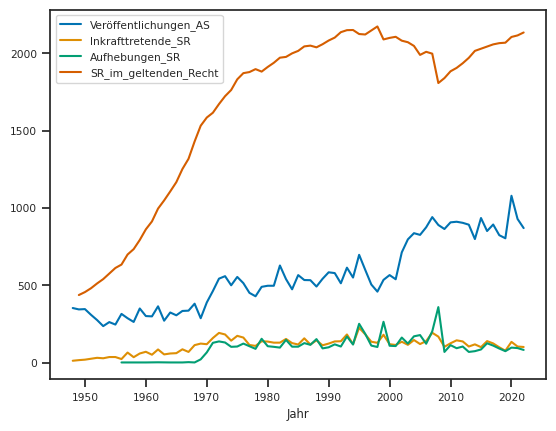

In [33]:
fig,ax = plt.subplots()
df_AS.drop(0).plot(ax=ax,x='Jahr',y='Veröffentlichungen_AS',kind='line')
df_SR_i.drop(0).plot(ax=ax,x='Jahr',y='Inkrafttretende_SR',kind='line')
df_SR_a.drop(0).plot(ax=ax,x='Jahr',y='Aufhebungen_SR',kind='line')
df_SR_gR.drop(0).plot(ax=ax,x='Jahr',y='SR_im_geltenden_Recht',kind='line')

Der Peak im Jahr 2020 ist wahrscheinlich mitverursacht durch die Menge an Covid Verordnungen (z.B. Einreisebestimmungen), welche teilweise wöchentlich geändert wurden.